# **BERTopic**
## ArXiv Articles: Computation and Language


In [1]:
# Load Data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata from the dataset
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/Users/camcortes/Documents/Hands On LLMs/PlayScraper-API/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **A Common Pipeline for Text Clustering**
## 1. Embedding Documents


In [2]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches: 100%|██████████| 1405/1405 [07:31<00:00,  3.11it/s]


In [3]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## 2. Reducing the Dimensionality of Embeddings

In [4]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric="cosine", random_state=42
)
reduce_embeddings = umap_model.fit_transform(embeddings)

/Users/camcortes/Documents/Hands On LLMs/PlayScraper-API/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 3. Cluster the Reduced Embeddings

In [5]:
from hdbscan import HDBSCAN

# Ajustamos el modelo HDBSCAN y extraemos los clusters

# min_cluster_size=50: Define el tamaño mínimo de un cluster. Se escoge 50 para asegurar que cada cluster tenga suficiente cantidad de puntos y evitar clusters pequeños/no significativos.
# metric="euclidean": Usamos la distancia euclidiana porque es estándar, y funciona bien cuando los embeddings ya han sido reducidos de dimensionalidad y normalizados.
# cluster_selection_method="eom": "EOM" (excess of mass) permite una selección más robusta de clusters, capturando mejor la densidad de los datos.
# prediction_data=True: Permite realizar predicciones de probabilidad posteriormente, útil para analizar la confianza de la asignación de clusters.

hdbscan_model = HDBSCAN(
    min_cluster_size=50,            # Tamaño mínimo del cluster, define la granularidad de los grupos
    metric="euclidean",             # Métrica de distancia usada para comparar puntos
    cluster_selection_method="eom" # Método avanzado para la selección óptima de clusters
).fit(reduce_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/Users/camcortes/Documents/Hands On LLMs/PlayScraper-API/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/camcortes/Documents/Hands On LLMs/PlayScraper-API/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can eit

155

## **Inspecting the Clusters**
Manually inspect the first three documents in cluster 0:

In [6]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [7]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# # Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]


/Users/camcortes/Documents/Hands On LLMs/PlayScraper-API/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Static Plot

(np.float64(-6.852184677124024),
 np.float64(11.202986145019532),
 np.float64(-1.7403558641672134),
 np.float64(18.436594799160957))

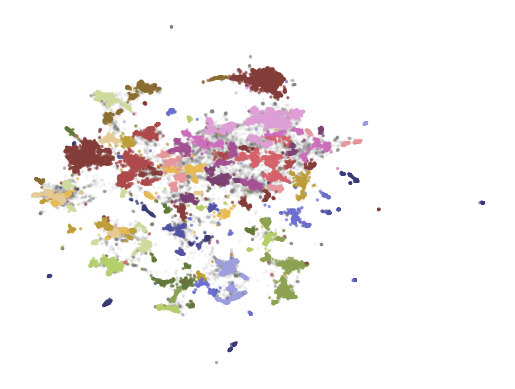

In [8]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

## From Text Clustering to Topic Modeling
## **BERTopic: A Modular Topic Modeling Framework**

In [9]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-11-21 23:42:44,738 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 23:43:03,114 - BERTopic - Dimensionality - Completed ✓
2025-11-21 23:43:03,115 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 23:43:03,642 - BERTopic - Cluster - Completed ✓
2025-11-21 23:43:03,647 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 23:43:04,943 - BERTopic - Representation - Completed ✓


In [10]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14219                               -1_the_of_and_to   
1        0   2181                 0_question_qa_questions_answer   
2        1   2151                   1_speech_asr_recognition_end   
3        2   1031               2_translation_nmt_machine_neural   
4        3    898  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51  151_tokenization_subword_tokenizer_tokenizers   
153    152     51           152_translation_indian_hindi_machine   
154    153     50                153_recipes_recipe_cooking_food   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, qa, questions, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [translation, nmt, machine, neural, bleu, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [tokenization, subword, tokenizer, tokenizers,...   
153  [translation, indian, hindi, machine, smt, sta...   
154  [recipes, recipe, cooking, food, ingredients, ...   

                                   Representative_Docs  
0    [  Recent breakthroughs in Natural Language Pr...  
1    [  In recent years, there have been amazing ad...  
2    [  End-to-end Speech Translation (ST) models h...  
3    [  In this paper, we introduce a hybrid search...  
4    [  In this paper, we present a model for gener...  
..                                                 ...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  Tokenization is a foundational step in Natu...  
153  [  We present in this paper our work on compar...  
154  [  Decoding the core of procedural texts, exem...  

[155 rows x 5 columns]

Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the get_topic() function:


In [11]:
topic_model.get_topic(0)

[('question', np.float64(0.021056261898275586)),
 ('qa', np.float64(0.01599431134706533)),
 ('questions', np.float64(0.015718108468821063)),
 ('answer', np.float64(0.015554594478592738)),
 ('answering', np.float64(0.01467306561256826)),
 ('answers', np.float64(0.009526235071698346)),
 ('retrieval', np.float64(0.009441091212769625)),
 ('comprehension', np.float64(0.007859737706814248)),
 ('reading', np.float64(0.007303450948569932)),
 ('the', np.float64(0.006212480587569639))]

We can use the find_topics() function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [12]:
topic_model.find_topics("topic modeling")

([26, -1, 43, 98, 33],
 [np.float32(0.9548466),
  np.float32(0.91252387),
  np.float32(0.9084965),
  np.float32(0.90586483),
  np.float32(0.9050922)])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [13]:
topic_model.get_topic(22)

[('commonsense', np.float64(0.07313269156206582)),
 ('knowledge', np.float64(0.024684370227435894)),
 ('reasoning', np.float64(0.01990447427264103)),
 ('models', np.float64(0.006831802064259916)),
 ('graph', np.float64(0.006821886035924481)),
 ('graphs', np.float64(0.006628866220944527)),
 ('that', np.float64(0.006508725841265524)),
 ('answering', np.float64(0.006216113647606683)),
 ('question', np.float64(0.006134850314795933)),
 ('on', np.float64(0.006000553415906716))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [14]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

26

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

## **Visualizations**
### Visualize Documents

In [15]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)
# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

## From Text Clustering to Topic Modeling
## **BERTopic: A Modular Topic Modeling Framework**

In [16]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [17]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [18]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

Representation Models
In these examples that follow, we will update our topic representations after having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [19]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [20]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df

## KeyBERTInspired

In [21]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0  answering | comprehension | questions | answer...  
1  translation | language | speech | multilingual...  
2  translation | translate | translations | trans...  
3  summarization | summarizers | summaries | summ...  
4  hate | hateful | language | cyberbullying | of...

## Maximal Marginal Relevance

In [22]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0   questions | comprehension | knowledge | to | hop  
1           speech | asr | error | model | automatic  
2  translation | nmt | bleu | parallel | multilin...  
3  summarization | extractive | factual | documen...  
4        hate | toxic | social | abusive | platforms

## **Text Generation**
## Flan-T5

In [24]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Device set to use mps:0
100%|██████████| 155/155 [01:09<00:00,  2.23it/s]


Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                    Updated  
0  Multi-hop question answering |  |  |  |   
1    Speech-to-text translation |  |  |  |   
2    Neural Machine Translation |  |  |  |   
3                 Summarization |  |  |  |   
4                  Science/Tech |  |  |  |

## OpenAI

In [30]:
import os
import openai
from bertopic.representation import OpenAI
from dotenv import load_dotenv

# Load our API key
load_dotenv()

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-4o-mini
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
representation_model = OpenAI(
    client, model="gpt-4o-mini", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 155/155 [02:10<00:00,  1.18it/s]


Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0  Multi-hop Question Answering and Retrieval Models  
1  End-to-End Speech Translation and Recognition ...  
2  Enhancements in Neural Machine Translation thr...  
3   Document Summarization Techniques and Evaluation  
4              Hate Speech Detection on Social Media

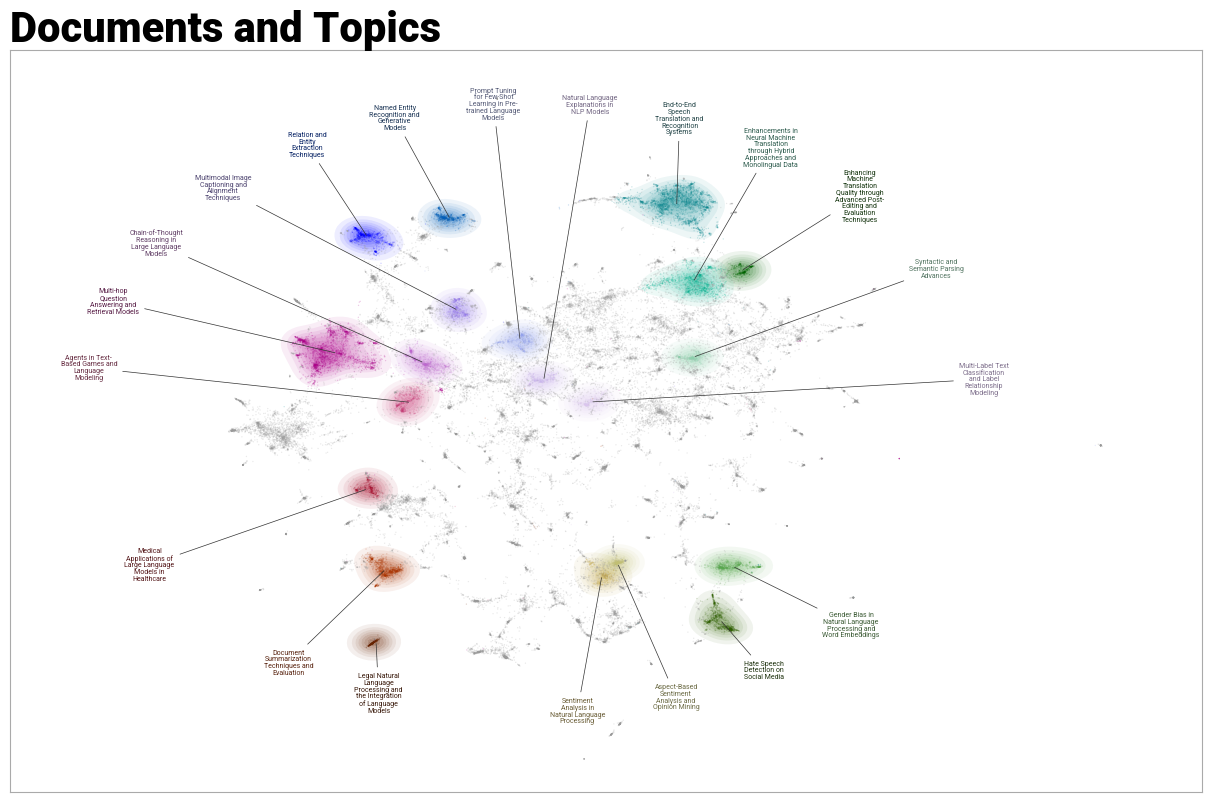

In [38]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)
plt.savefig("datamapplot.png", dpi=300)